In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, 
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold


In [4]:
# Генерация данных
np.random.seed(0)
l = 100
n = 2
X1 = np.array([[-1,-1]]) + 0.5*np.random.randn(l, n)
X2 = np.array([[1,1]]) + 0.5*np.random.randn(l, n)
X3 = np.array([[-1,1]]) + 0.5*np.random.randn(l, n)

X = np.vstack([X1, X2, X3])
y = np.hstack([[0]*l, [1]*l, [2]*l])

# В отличии от предыдущего семинара добавляем дополнительный признак все элементы которого =1
X = np.hstack([X, np.ones([len(X), 1])])


In [5]:
# обучение моделей
# Добавляем параметр fit_intercept=False чтобы внутри черного ящика своя константта не добавлялась.
# Иначе будет линейная зависимость между добавленной нами единицей и этой константой, что повлияет на результат.
models = []
model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==0, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==1, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==2, dtype=np.int64))
models.append(model)

In [6]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-models[k].coef_[0][1] + c)/models[k].coef_[0][0], -1
    x2, y2 = -(models[k].coef_[0][1] + c)/models[k].coef_[0][0], 1
    
    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)
    
    return x_axis, y_axis

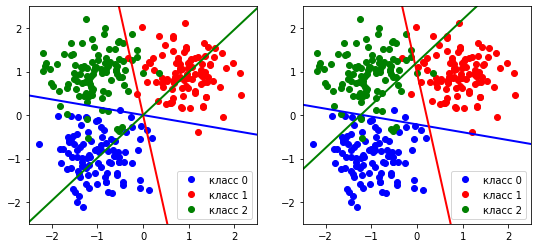

In [7]:
cols = ['blue', 'red', 'green']
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].set_xlim((-2.5, 2.5)), ax[i].set_ylim((-2.5, 2.5))

for k in np.unique(y):
    ax[0].plot(X[y==k,0], X[y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])
    ax[1].plot(X[y==k,0], X[y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])

for k in np.unique(y):
    ax[0].plot(*get_line(*models[k].coef_[0][:2]), linewidth=2, color=cols[k])
    ax[1].plot(*get_line(*models[k].coef_[0]), linewidth=2, color=cols[k])

ax[0].legend(loc='best'), ax[1].legend(loc='best')
plt.show()


In [8]:
# Перейдем к задаче оптимизации.
# Нашли аналитическое решение из общего вида оптимизации (можно не всегда).
# 

np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l) # генерируем синусоидальный сигнал с шумом

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T # vstack соединяет массивы

# Решение задачи регрессии
w = np.linalg.inv(X.T@X)@X.T@Y

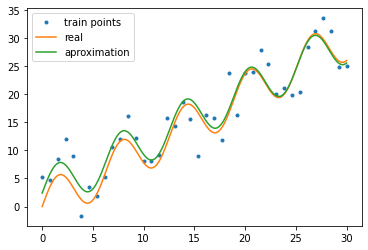

In [9]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

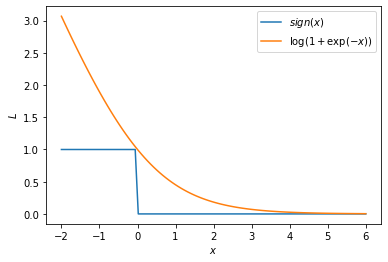

In [10]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)
def upper_bound(x):
    return np.log2(1+np.exp(-x))

x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

In [11]:
# Применим метод градиентного спуска на некоторой случайной выборке.
# Пакет torch необходим для вычисления градиента.
# torch аперирует объектами типа тензор.

torch.manual_seed(0)

l = 1000
n = 2

X = torch.randn([l, n])
w_true = torch.randn([n])
Y = torch.ones([l])
Y[X@w_true < 0] = -1

In [12]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss_sqrt = []  
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))
    
    # выбираем случайный элемент из выбооки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/np.sqrt(k)
    
    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))
    
    # считаем g с крышкой
    q.backward()
    
    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [13]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9980000257492065


In [14]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []  
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss.append(torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))
    
    # выбираем случайный элемент из выбооки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/k
    
    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))
    
    # считаем g с крышкой
    q.backward()
    
    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [15]:
# Типичный алгоритм машинного обучения. Функции не нужно прописывать вручную, все есть в torch.

torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X, Y) # Задаем датасет
# Функция DataLoader автоматически выбирает случайный элемент из датасета. 
# Cвойство batch_size позволяет оперировать не единичными элементами, а наборами - батчами. 
# В данном случае берем по одному элементу. 
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Метод стахастического градиентного спуска (SGD) прописан в torch.
optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                              lambda k: 1/np.sqrt(k+1))

list_of_loss_torch = []
# Вызываем случайный элемент (x,y)
for x, y in generator:
    optimizer.zero_grad()

    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))
        
    q = torch.log2(1+torch.exp(-y*(x@w))).mean()
    
    q.backward()
    
    optimizer.step()
    scheduler.step()

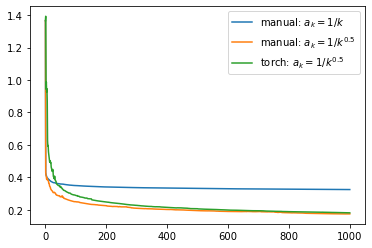

In [16]:
plt.plot(list_of_loss, label="manual: $a_k = 1/k$")
plt.plot(list_of_loss_sqrt, label="manual: $a_k = 1/k^{0.5}$")
plt.plot(list_of_loss_torch, label="torch: $a_k = 1/k^{0.5}$")
plt.legend(loc='best')
plt.show()

In [17]:
np.random.seed(0)
l = 50000
n = 2

X = np.random.randn(l, n)
w = np.random.randn(n)
Y = np.random.binomial(n=1, p=expit(X@w))

In [18]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

models_l2 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l2', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l2[gamma] = model
    
models_l1 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l1', C=2/gamma, fit_intercept=False, 
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l1[gamma] = model


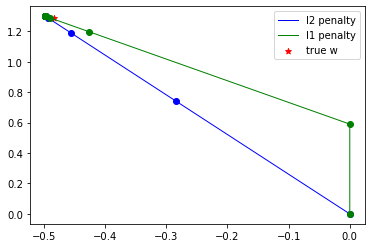

In [19]:
x = [models_l2[gamma].coef_[0][0] for gamma in models_l2]
y = [models_l2[gamma].coef_[0][1] for gamma in models_l2]

plt.plot(x, y, 'bo')
plt.plot(x, y, 'b-', linewidth=1, label='l2 penalty')

x = [models_l1[gamma].coef_[0][0] for gamma in models_l1]
y = [models_l1[gamma].coef_[0][1] for gamma in models_l1]

plt.plot(x, y, 'go')
plt.plot(x, y, 'g-', linewidth=1, label='l1 penalty')
    
    
plt.scatter(w[0], w[1], marker='*', c='r', label='true w')
plt.legend(loc='best')
plt.show()

In [20]:
np.random.seed(0)
l = 1000
n = 2


X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [21]:
loo = LeaveOneOut()
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))
        
    gamma_scores[gamma] = np.mean(list_of_scores)


In [22]:
best_gamma = sorted(gamma_scores, 
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False, 
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.768


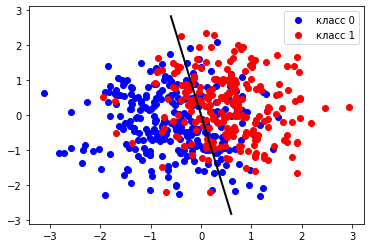

In [23]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o', 
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6), 
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()